In [1030]:
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import copy
from scipy.integrate import odeint
from scipy.optimize import root_scalar
import random 
import time
from mpmath import *

In [1022]:
def network_iter(G,infected,suscep,removed):

    iteration = 1000        #initial parameters for network sir model 
    counter = 0
   
    gamma_inverse = 5
    I = 1
    S = N-I
    R = 0
    dt = 1

    I_record=[]
    S_record=[]
    R_record=[]
    p_record=[]


    while counter<iteration:

        new_infected = []

        for sus in suscep:
            nei = G[sus].keys()       # get current susceptible's neighbors
            infected_nei = [n for n in nei if G.nodes[n]['status']=='infected']   # get infectious neighbors
            p_infection = 1-np.power((1-beta*dt),len(infected_nei))#beta*len(infected_nei)/len(nei)
            if p_infection!=0:
                p_record.append(p_infection)
            
            inf_status = np.random.binomial(1,p_infection)
            if inf_status==1:
                new_infected.append(sus)
                I=I+1
                S=S-1

        new_removed = []

        for inf in infected:

            G.nodes[inf]['inf_dur']=G.nodes[inf]['inf_dur']+dt

            if G.nodes[inf]['inf_dur']>=gamma_inverse:
                new_removed.append(inf)
                I=I-1
                R=R+1


        new_infected= list(dict.fromkeys(new_infected))
        new_removed = list(dict.fromkeys(new_removed))

        for re in new_removed:
            infected.remove(re)
            G.nodes[re]['status']='removed'

        for inf in new_infected:
            suscep.remove(inf)
            G.nodes[inf]['status']='infected'
            G.nodes[inf]['inf_dur']=0

        infected.extend(new_infected)
        removed.extend(new_removed)
        counter = counter + 1
        

        I_record.append(len(infected))
        R_record.append(len(removed))
        S_record.append(len(suscep))

    
        if len(infected)==0:
            break
            
    return S_record,I_record,R_record,p_record

In [1085]:
N=1000           #population 
m=4          #initial nodes
N_nodes = set(np.arange(0,N,1))             #set of 100 nodes
G = nx.barabasi_albert_graph(N,m)               #create graph\
degree_seq = list(G.degree())
min_deg= np.min(np.array(degree_seq)[:,1])
max_deg= np.max(np.array(degree_seq)[:,1])
print(nx.average_clustering(G))

0.02828327311658539


Newman's Spread of epidemic disease on networks
$$\\T_{c} = \frac{<k>}{<k^{2}>-<k>}$$\
$$\\<k> = \sum k p_{k} \text{, where } p_{k} = \frac{2m(m+1)}{k(k+1)(k+2)}$$
$$T = 1- \int_{0}^{\inf} dr \sum_{\tau} P(r)P(\tau)(1-r)^{\tau}$$
$$T = 1-(1-\beta)^{\gamma} \text{ where }  \beta = 0.5, \gamma = 5 \text{ in our simulation}$$

In [1076]:
all_m=[]
k_mean = 0
k_sm = 0
for k in range(1,N):
    k_mean = k_mean + p_k(m,k)*k
    k_sm = k_sm + p_k(m,k)*k**2


thresh = k_mean/(k_sm-k_mean) 
thresh 


0.10003091382975349


$$\text{degree distribution generating function: }$$
$$\\ G_{0}(x) = \sum p_{k} x^{k} $$
$$\text{degrees of vertices reached by following a randomly chosen edge: }$$
$$\\G_{1}(x) = \frac{G'_{0}(x)}{<k>} $$

$$<s> = 1+ \frac{TG'_{0}(1)}{1-TG'_{1}(1)}$$

In [1077]:
def mean_s(T,k_m,k_sq):
    return 1+((T*k_m)/(1-(T*((k_sq-k_m)/k_m))))

In [1083]:
T = np.linspace(0.03,thresh,18)
above_T = np.linspace(thresh,0.9,18)
s = mean_s(T,k_mean,k_sm)
b_all = 1-np.power((1-T),1/5)
b_ab_all = 1-np.power((1-above_T),1/5)
print(T)
print(b_all)
print(s)
print(b_ab_all)

[0.03       0.03411947 0.03823893 0.0423584  0.04647786 0.05059733
 0.05471679 0.05883626 0.06295572 0.06707519 0.07119466 0.07531412
 0.07943359 0.08355305 0.08767252 0.09179198 0.09591145 0.10003091]
[0.00607332 0.00691898 0.00776752 0.00861898 0.00947337 0.01033072
 0.01119105 0.01205439 0.01292075 0.01379017 0.01466266 0.01553825
 0.01641697 0.01729885 0.0181839  0.01907215 0.01996363 0.02085836]
[ 1.855317    2.03356313  2.2355754   2.46644658  2.7328364   3.04362452
  3.41091957  3.85167363  4.39037303  5.06374729  5.9295142   7.08387007
  8.69996829 11.12411562 15.16436117 23.24485228 47.4863256          inf]
[0.02085836 0.03131884 0.0422517  0.05370784 0.06574721 0.0784412
 0.09187577 0.10615587 0.12141153 0.13780685 0.15555336 0.17493074
 0.19632061 0.22026462 0.24757187 0.27953751 0.31845091 0.36904266]


C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [978]:
final_size = []
for b in b_ab_all:
    beta =b
    size = []
    for i in range(1,100):
        infected= random.sample(N_nodes,1)           #select 2 nodes at random for infected
        suscep=[s for s in N_nodes if s not in infected]  
        removed=[]

        for inf in infected:                           #initialize node attribute
            G.nodes[inf]['status']='infected'
            G.nodes[inf]['inf_dur']= 0

        for sus in suscep:
            G.nodes[sus]['status']='susceptible'

        S,I,R,p = network_iter(G, infected,suscep,removed)
        size.append(R[-1])
    
    final_size.append(np.mean(size)/N)

print(final_size)

[0.04343434343434343, 0.18185858585858586, 0.421050505050505, 0.4875656565656566, 0.6534141414141414, 0.7546161616161616, 0.8297575757575758, 0.8922121212121212, 0.9517979797979798, 0.9653434343434343, 0.9852424242424243, 0.9807878787878788, 0.9945959595959596, 0.9975656565656565, 0.998969696969697, 0.9996161616161616, 0.9998383838383839, 0.9999494949494949]


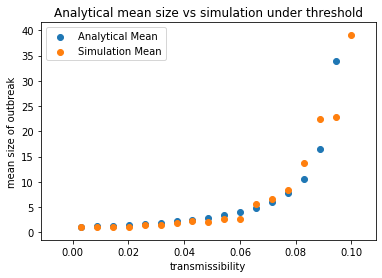

In [960]:
fig,ax = plt.subplots()
ax.scatter(T,s,label='Analytical Mean')
ax.scatter(T,final_size,label='Simulation Mean')
ax.set_xlabel('transmissibility')
ax.set_ylabel('mean size of outbreak')
plt.title('Analytical mean size vs simulation under threshold')
ax.legend()

In [1070]:
def p_k(m,k):
    return 2*(m)*(m+1)/(k*(k+1)*(k+2))
    
def G_0(x):
    G = 0
    for k in range(min_deg,1000):
        G = G + p_k(m,k)*x**(k)
        
    return G
def G_0_t(x,t):
    
    G_0_t = 0
    
    for k in range(min_deg,1000):
        G_0_t = G_0_t + p_k(m,k)*(1+(x-1)*t)**k
        
    return G_0_t
        
        
def G_0_prime(x):
    G_p=0
    for k in range(min_deg,1000):
        G_p= G_p + k*p_k(m,k)*x**(k-1)
        
    return G_p

def G_0_pp(x):
    G_pp=0
    for k in range(min_deg,1000):
        G_pp= G_pp + k*(k-1)*p_k(m,k)*x**(k-2)
        
    return G_pp
    

def G_0_prime_t(x,t):
    G_p_t=0
    for k in range(min_deg,1000):
        G_p_t= G_p_t + k*p_k(m,k)*(1+(x-1)*t)**(k-1)
        
    return G_p_t

def S_T(G):
    return 1-G


def fun(u):
    
    return u-(G_0_prime_t(u,t)/(G_0_prime(1)))

def G_0_ppt(u,t):
    
    pp = 0
    
    for k in range(min_deg,1000): 
        pp = pp+ t*k*(k-1)*p_k(m,k)*(1+(u-1)*t)**(k-2)
        
    return pp
        

def fun_p(u):
    
    return 1-G_0_ppt(u,t)/(G_0_prime(1))

$$S(T) = 1- G_{0}(u;T)$$

$$u = G_1(u;T)$$

$$\text{In Degree Distribution Terms: }$$

$$u = \frac{\sum kp_{k}(1+(u-1)T)^{k-1}}{\sum kp_{k}}$$

[0.04343434343434343, 0.18185858585858586, 0.421050505050505, 0.4875656565656566, 0.6534141414141414, 0.7546161616161616, 0.8297575757575758, 0.8922121212121212, 0.9517979797979798, 0.9653434343434343, 0.9852424242424243, 0.9807878787878788, 0.9945959595959596, 0.9975656565656565, 0.998969696969697, 0.9996161616161616, 0.9998383838383839, 0.9999494949494949]


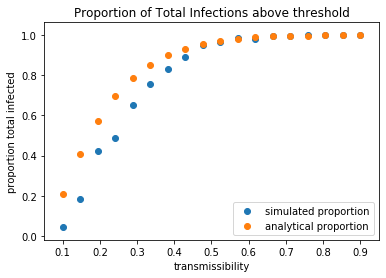

In [1084]:
ana_epi_size = []
for i in range(len(above_T)):
    t = above_T[i]
    u= root_scalar(fun,x0=0.3,fprime=fun_p,method='newton')
    s = S_T(G_0_t(u.root,t))
    ana_epi_size.append(s)
    

fig,ax = plt.subplots()
ax.scatter(above_T,final_size,label='simulated proportion')
ax.scatter(above_T,ana_epi_size,label='analytical proportion')
ax.set_xlabel('transmissibility')
ax.set_ylabel('proportion total infected')
plt.title('Proportion of Total Infections above threshold')
ax.legend()
print(final_size)